# COMPAS 광양시 재활용품 자동수거기 설치를 위한 최적위치 선정 공모전
- 제출본에서 수정된 부분
    - 틀린 좌표 수정 & 좌표 반올림하는 부분 주석 추가
    - API key 숨김
- GitHub에는 folium map 표시 안 됨

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine as hs
import geopandas as gpd
import folium
from scipy.interpolate import interp1d
from geoband.API import *

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# 제공된 1,3,4,6,7,8,9,10번 csv파일 받아오기

In [2]:
GetCompasData('SBJ_2107_002','1','1.광양시_공동주택_분리수거현황.csv')
GetCompasData('SBJ_2107_002','3','3.광양시_금호동_집적장별_재활용품통계.csv')
GetCompasData('SBJ_2107_002','4','4.광양시_건축물_표제부.csv')
GetCompasData('SBJ_2107_002','6','6.광양시_법정경계(읍면동).geojson')
GetCompasData('SBJ_2107_002','7','7.광양시_도로명주소(건물).geojson')
GetCompasData('SBJ_2107_002','8','8.광양시_도로명주소(건물출입구).geojson')
GetCompasData('SBJ_2107_002','9','9.광양시_지적도.geojson')
GetCompasData('SBJ_2107_002','10','10.광양시_인구정보(총인구).geojson')

In [3]:
# 표제부에 있는 위경도가 실제 건물의 번지수와 일치하는 위경도와 다를 경우, 
# 표제부의 데이터가 잘못됐다고 판단하여 정확한 위/경도 데이터로 교체했다.
df4_edited = pd.read_csv('4.광양시_건축물_표제부.csv')
df1_edited = pd.read_csv('1.광양시_공동주택_분리수거현황.csv')

# 4번 데이터 틀린 좌표 수정 
# 광양의 봄 프리미엄2 : (34.975916, 127.7160134) -> (34.9673253, 127.7210248)
idx = df4_edited.loc[df4_edited['lat'] == 34.975916].index
df4_edited.loc[idx , 'lat'] = 34.9673253
df4_edited.loc[idx , 'lon'] = 127.7210248

# 1, 4번 데이터 좌표 소수점 6번째 자리까지 반올림
for i in range(len(df1_edited)):
    df1_edited.at[i, 'lat'] = round(df1_edited.loc[i][3],6) 
    df1_edited.at[i, 'lon'] = round(df1_edited.loc[i][2],6)

for i in range(len(df4_edited)):
    df4_edited.at[i, 'lat'] = round(df4_edited.loc[i][16],6) 
    df4_edited.at[i, 'lon'] = round(df4_edited.loc[i][15],6)

df4_edited.to_csv('4.광양시_건축물_표제부.csv', index=False)
df1_edited.to_csv('1.광양시_공동주택_분리수거현황.csv', index=False)

# 현재 설치된 분리수거장 운영 분석

In [4]:
df1 = pd.read_csv('1.광양시_공동주택_분리수거현황.csv')
df4 = pd.read_csv('4.광양시_건축물_표제부.csv')
df11 = df1[['lat', 'lon']]
df44 = df4[['lat', 'lon']]
m = folium.Map(location = (34.9363848, 127.7310154), 
               zoom_start = 11,
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/YOUR_API_KEY/Base/{z}/{y}/{x}.png',               
               attr = '광양시'
              )

# 분리수거장 설치되어있지 않은 공동주택
for index, row in df44.iterrows():
    folium.Marker([row['lat'], row['lon']]).add_to(m)

# 분리수거장 설치되어있는 공동주택
for index, row in df11.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='green', icon='recycle', prefix='fa')).add_to(m)

m

# 3번 데이터 전처리 (아파트별 쓰레기 데이터 정리 및 무게합, 부피합 컬럼 추가)

In [5]:
import pandas as pd

# 3번 데이터 '3.광양시_금호동_집적장별_재활용품통계.csv' 불러오기
df3 = pd.read_csv('3.광양시_금호동_집적장별_재활용품통계.csv')


# 같은 아파트 이름 동일하게 변경(apt_nm에서 동 지우고 아파트 이름으로 통일)
for i in range(len(df3)):
    name = df3.loc[i][0].split(" ")[0]
    df3.at[i, 'apt_nm'] = name

# 같은 이름의 아파트 각 쓰레기 품목별로 모두 더하기 
apt_name = ''
for i in range(len(df3)):
    if df3.iloc[i,0] != apt_name:
        idx = i
        apt_name = df3.iloc[idx,0]
    else:
        df3.iloc[idx,1] += df3.iloc[i,1]
        df3.iloc[idx,2] += df3.iloc[i,2]
        df3.iloc[idx,3] += df3.iloc[i,3]
        df3.iloc[idx,4] += df3.iloc[i,4]
        df3.iloc[idx,5] += df3.iloc[i,5]
        df3.at[i,'can'] = 'NaN'
        df3.at[i,'plastic'] = 'NaN'
        df3.at[i,'glass'] = 'NaN'
        df3.at[i,'paper'] = 'NaN'
        df3.at[i,'scrapmetal'] = 'NaN'
df3_ = df3.dropna(axis = 0)                # df3_ : 1주일별 아파트당 각 쓰레기 품목 무게 합 데이터     
# 3번데이터에 부피합, 무게합 컬럼 추가하기
df3_['sum_volume'] = 0
df3_['sum_weight'] = 0

# 아파트별 전체 쓰래기 무게 합
for i in range(len(df3_)):
    df3_.iloc[i,7] = sum(df3_.iloc[i,1:6])
    
# 1일간의 무게합으로 변경
for i in range(len(df3_)):
    df3_.iloc[i,7] = df3_.iloc[i,7]/7

# Average Bulk density (kg/m^3)
can_density = 74.6
plastic_density = 43.6
glass_density = 379
paper_density = 200
scrapmetal_density = 172.3

# 위의 밀도 값을 이용하여, 각 쓰레기 품목 '무게->부피' 로 변경
for i in range(len(df3_)):
    df3_.iloc[i,1] = df3_.iloc[i,1] / can_density   
    df3_.iloc[i,2] = df3_.iloc[i,2] / plastic_density
    df3_.iloc[i,3] = df3_.iloc[i,3] / glass_density
    df3_.iloc[i,4] = df3_.iloc[i,4] / paper_density
    df3_.iloc[i,5] = df3_.iloc[i,5] / scrapmetal_density
    
# 아파트별 전체 쓰래기 부피 합
 # 쓰레기 부피 합 열 추가
for i in range(len(df3_)):
    df3_.iloc[i,6] = sum(df3_.iloc[i,1:6])
    
# 7일간의 부피합 1일간의 부피합으로 변경
for i in range(len(df3_)):
    df3_.iloc[i,6] = df3_.iloc[i,6]/7
# 결과물 : df3_

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/app-root/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [6]:
df3_

,apt_nm,can,plastic,glass,paper,scrapmetal,sum_volume,sum_weight
0,동백아파트,0.063003,0.502294,0.008179,0.0025,0.020894,0.085267,4.828571
4,목련빌라,0.156836,1.222477,0.019525,0.0060,0.049913,0.207822,11.742857
9,장미아파트,0.091153,0.697248,0.011082,0.0035,0.029600,0.118940,6.742857
15,장미연립,0.014745,0.112385,0.001847,0.0005,0.004643,0.019160,1.085714
16,목련연립,0.057641,0.447248,0.007388,0.0030,0.019153,0.076347,4.357143
21,백합아파트,0.168901,1.293578,0.020844,0.0065,0.055136,0.220709,12.528571
28,매화연립,0.140751,1.087156,0.017414,0.0050,0.044689,0.185001,10.457143
32,사랑아파트,0.276139,2.103211,0.033773,0.0095,0.088218,0.358692,20.314286
38,초원아파트,0.104558,0.802752,0.012665,0.0040,0.033662,0.136805,7.742857
40,송죽아파트,0.006702,0.052752,0.001055,0.0000,0.002322,0.008976,0.514286


# 4번 데이터 전처리(금호동 아파트 세대수 합치기)

In [7]:
# 4번데이터 불러오기
df4 = pd.read_csv("4.광양시_건축물_표제부.csv")

# 'land_location' 행에서 '전라남도 광양시' 제거
for i in range(len(df4)):
    df4.iloc[i,0] = df4.iloc[i,0].replace("전라남도 광양시 ", "")

# 'bun' , 'ji' 행에서 "," 제거  
for i in range(len(df4['bun'])):
    df4['bun'][i] = df4['bun'][i].replace('"', "")
    df4['ji'][i] = df4['ji'][i].replace('"', "")
    
# 'purpose_cd' 가 2000인 공동주택을 제외한 행 제거  '
idx_nm = df4[df4['purpose_cd']!=2000].index
df4 = df4.drop(idx_nm)

# 공동주택 건물 이름에 결측값이 있는 행 제거
df4 = df4.dropna(subset=["bldg_nm"])

# household_cnt'(세대수)값이 0인 행 제거
idx = df4[df4['household_cnt'] == 0].index
df4 = df4.drop(idx)

# 'bldg_nm' 순으로 정렬
df4 = df4.sort_values(by=['bldg_nm'])

# 필요없는 행 제거
df4 = df4.drop(['land_gbn','purpose_cd', 'etc_purpose_nm','family_cnt','ho_cnt' ], axis = 1)

# 금호동 데이터만 추출(df4_guemho)
idx = df4[df4['emd_cd'] != 11000].index
df4_guemho = df4.drop(idx)

# 금호동 내에서 같은 아파트끼리 세대수 합치기
bldg_name = ''
for i in range(len(df4_guemho)):
    if df4_guemho.iloc[i,5] != bldg_name:
        idx = i
        bldg_name = df4_guemho.iloc[idx,5]
        continue
    else:
        df4_guemho.iloc[idx,9] += df4_guemho.iloc[i,9]
        df4_guemho.iloc[i,5] = 0
idx_ = df4_guemho[df4_guemho['bldg_nm'] == 0].index
df4_guemho = df4_guemho.drop(idx_)

# 예외 처리 ('bldg_nm'에서 동백아파트, 동백아파트5동 합쳐지지 않은것 합치기)
df4_guemho.iloc[0,9]+=15
idx_1 = df4_guemho[df4_guemho['bldg_nm'] == '동백아파트5동'].index
df4_guemho = df4_guemho.drop(idx_1)

# 결과물 : df4_guemho

/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
df4_guemho

,land_location,sgg_cd,emd_cd,bun,ji,bldg_nm,dong_nm,main_annex_gbn,purpose_nm,household_cnt,lon,lat
615,금호동 714번지,46230,11000,0714,0000,동백아파트,6동,주건축물,공동주택,350,127.730299,34.937925
552,금호동 624-7번지,46230,11000,0624,0007,매화아파트,23동,주건축물,공동주택,572,127.720397,34.936325
588,금호동 684번지,46230,11000,0684,0000,목련빌라,2동,주건축물,공동주택,567,127.728429,34.940589
643,금호동 717번지,46230,11000,0717,0000,목련연립아파트,21동,주건축물,공동주택,626,127.732675,34.937696
498,금호동 624-1번지,46230,11000,0624,0001,백합아파트,16동,주건축물,공동주택,852,127.723044,34.933698
492,금호동 624-13번지,46230,11000,0624,0013,사랑아파트,9동,주건축물,공동주택,903,127.717120,34.934343
712,금호동 826번지,46230,11000,0826,0000,송죽아파트,2동,주건축물,공동주택,210,127.718450,34.939268
667,금호동 724번지,46230,11000,0724,0000,장미아파트,4동,주건축물,공동주택,662,127.733765,34.942701
695,금호동 733번지,46230,11000,0733,0000,장미연립아파트,1동,주건축물,공동주택,172,127.731891,34.943049
699,금호동 825번지,46230,11000,0825,0000,초원아파트,4동,주건축물,공동주택,336,127.720248,34.938398


# 3번, 4번 전처리 데이터 조인

In [9]:
# 3번 전처리한 데이터와 조인하기위해 bldg_nm을 3번데이터 기준으로 변경
df4_guemho.iloc[1,5] = df4_guemho.iloc[1,5].replace("매화아파트","매화연립")
df4_guemho.iloc[3,5] = df4_guemho.iloc[3,5].replace("목련연립아파트","목련연립")
df4_guemho.iloc[8,5] = df4_guemho.iloc[8,5].replace("장미연립아파트","장미연립")

# 건물명을 기준으로 df3_로 df4_guemho를 left join (아파트당 세대수 표기하기 위하여)  결과 데이터 프레임 : df_join
df_join = pd.merge(df3_, df4_guemho, left_on='apt_nm', right_on='bldg_nm', how='left')  

# 필요없는 컬럼 제거
df_join = df_join.drop(['land_location','sgg_cd','emd_cd','bun','ji','bldg_nm','dong_nm','main_annex_gbn','purpose_nm'], axis = 1)


#최종 데이터프레임 => df_join

In [10]:
df_join

,apt_nm,can,plastic,glass,paper,scrapmetal,sum_volume,sum_weight,household_cnt,lon,lat
0,동백아파트,0.063003,0.502294,0.008179,0.0025,0.020894,0.085267,4.828571,350,127.730299,34.937925
1,목련빌라,0.156836,1.222477,0.019525,0.0060,0.049913,0.207822,11.742857,567,127.728429,34.940589
2,장미아파트,0.091153,0.697248,0.011082,0.0035,0.029600,0.118940,6.742857,662,127.733765,34.942701
3,장미연립,0.014745,0.112385,0.001847,0.0005,0.004643,0.019160,1.085714,172,127.731891,34.943049
4,목련연립,0.057641,0.447248,0.007388,0.0030,0.019153,0.076347,4.357143,626,127.732675,34.937696
5,백합아파트,0.168901,1.293578,0.020844,0.0065,0.055136,0.220709,12.528571,852,127.723044,34.933698
6,매화연립,0.140751,1.087156,0.017414,0.0050,0.044689,0.185001,10.457143,572,127.720397,34.936325
7,사랑아파트,0.276139,2.103211,0.033773,0.0095,0.088218,0.358692,20.314286,903,127.717120,34.934343
8,초원아파트,0.104558,0.802752,0.012665,0.0040,0.033662,0.136805,7.742857,336,127.720248,34.938398
9,송죽아파트,0.006702,0.052752,0.001055,0.0000,0.002322,0.008976,0.514286,210,127.718450,34.939268


# 금호동내 공동주택 세대수, 쓰레기 배출량 시각화

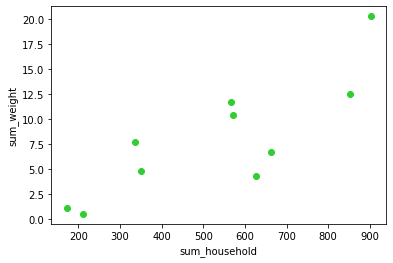

In [11]:
# 세대수, 쓰레기배출 무게 분포 시각화
import matplotlib.pyplot as plt

x = df_join['household_cnt']
y = df_join['sum_weight']
plt.scatter(x,y,color='limegreen')
plt.xlabel('sum_household')
plt.ylabel('sum_weight')
plt.show()

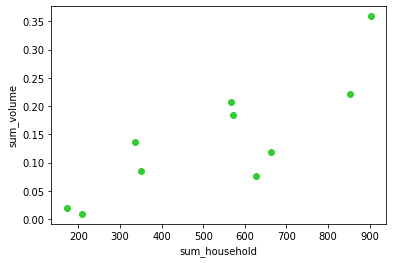

In [12]:
# 세대수, 쓰레기배출 부피 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x = df_join['household_cnt']
y = df_join['sum_volume']
plt.scatter(x,y,color = 'limegreen')
plt.xlabel('sum_household')
plt.ylabel('sum_volume')
plt.show()

In [13]:
# 세대수와 쓰레기 각 품목 및 합계와의 상관계수 확인
df_join.corr()

,can,plastic,glass,paper,scrapmetal,sum_volume,sum_weight,household_cnt,lon,lat
can,1.000000,0.999880,0.999814,0.991516,0.999834,0.999910,0.999923,0.830512,-0.460932,-0.637774
plastic,0.999880,1.000000,0.999913,0.992175,0.999698,0.999997,0.999986,0.829113,-0.456863,-0.637146
glass,0.999814,0.999913,1.000000,0.992164,0.999721,0.999919,0.999931,0.832071,-0.458004,-0.643470
paper,0.991516,0.992175,0.992164,1.000000,0.992696,0.992203,0.992391,0.867050,-0.389260,-0.646229
scrapmetal,0.999834,0.999698,0.999721,0.992696,1.000000,0.999749,0.999807,0.837011,-0.456858,-0.644948
sum_volume,0.999910,0.999997,0.999919,0.992203,0.999749,1.000000,0.999995,0.829773,-0.457088,-0.637642
sum_weight,0.999923,0.999986,0.999931,0.992391,0.999807,0.999995,1.000000,0.831065,-0.456700,-0.638856
household_cnt,0.830512,0.829113,0.832071,0.867050,0.837011,0.829773,0.831065,1.000000,-0.144807,-0.613847
lon,-0.460932,-0.456863,-0.458004,-0.389260,-0.456858,-0.457088,-0.456700,-0.144807,1.000000,0.627946
lat,-0.637774,-0.637146,-0.643470,-0.646229,-0.644948,-0.637642,-0.638856,-0.613847,0.627946,1.000000


In [14]:
# 선형회귀분석 (절편 = 0으로 고정)
from statsmodels.formula.api import ols
linear_model = ols('sum_volume ~ 0 + household_cnt', data = df_join).fit()
linear_model.summary()

/opt/app-root/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             sum_volume   R-squared (uncentered):                   0.887
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              70.68
Date:                Tue, 31 Aug 2021   Prob (F-statistic):                    1.49e-05
Time:                        16:26:41   Log-Likelihood:                          14.227
No. Observations:                  10   AIC:                                     -26.45
Df Residuals:                       9   BIC:                                     -26.15
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
household_cnt     0.0003   3.37e-05      8.407      0.000       0.000       0.000
==============================================================================
Omnibus:                        0.183   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.307
Skew:                           0.238   Prob(JB):                        0.858
Kurtosis:                       2.285   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

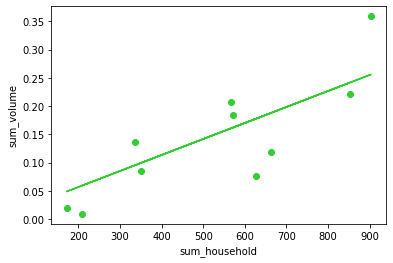

In [15]:
# 선형회귀 (절편제거) 시각화
x = df_join['household_cnt']
y = df_join['sum_volume']
y_pred = linear_model.predict(x)
plt.xlabel('sum_household')
plt.ylabel('sum_volume')
plt.scatter(x,y,color = 'limegreen')
plt.plot(x, y_pred,color = 'limegreen')
coefficient_x = linear_model.params[0]    # 선형회귀식에서의 x계수

In [16]:
coefficient_x   # 선형회귀식에서의 x계수

0.00028328851533712516

# 재활용품 수거기의 최적위치 선정

# 방법1, 방법2 공동 데이터 전처리

In [17]:
df = pd.read_csv('4.광양시_건축물_표제부.csv')
df = df[df['purpose_nm']=='공동주택']

# 금호동 & 그 외 지역 분리
df_khd = df[df['emd_cd']==11000]
df_others = df[df['emd_cd']!=11000]

# 위경도가 같은 row는 세대수 합치기
df = df.groupby(['lat', 'lon']).agg({'household_cnt': 'sum'}).reset_index() # 243 rows
df_khd = df_khd.groupby(['lat', 'lon']).agg({'household_cnt': 'sum'}).reset_index() # 22 rows
df_others = df_others.groupby(['lat', 'lon']).agg({'household_cnt': 'sum'}).reset_index() # 221 rows

In [18]:
# 기존 설치된 분리수거장 위/경도 데이터 생성
df_bin = pd.read_csv('1.광양시_공동주택_분리수거현황.csv')
df_bin = df_bin[['lat', 'lon']].drop_duplicates() # 92 rows
np_bin = df_bin.to_numpy()

In [19]:
#필요 함수 정의
# 가장 가까운 기존 분리수거함까지의 거리 계산 함수
# 위경도로 거리 계산 (단위: m)
def cal_distance(lat1, lon1, lat2, lon2):
    loc1 = (lat1, lon1)
    loc2 = (lat2, lon2)
    distance = hs.haversine(loc1, loc2, unit=hs.Unit.METERS)

    return distance

def closest_bin(lat, lon, np_bin):
    shortest = cal_distance(lat, lon, np_bin[0][0], np_bin[0][1]) # 초기값

    for point in np_bin[1:]:
        dis = cal_distance(lat, lon, point[0], point[1])

        if dis < shortest:
            shortest = dis
  
    return shortest

# 세대 수로 재활용품 부피 발생량 예측
def predict_recycle(household_cnt):
    return 0.0002832885153371252*household_cnt



# 방법1 데이터 전처리

In [20]:
# 반경 50km 이내에 기존 분리수거장이 있는 공동주택은 제외

# 금호동
df_khd['closest_bin'] = df_khd.apply(lambda x: closest_bin(x['lat'], x['lon'], np_bin), axis=1)
df_khd_50 = df_khd.drop(df_khd[df_khd.closest_bin < 50].index)[['lat', 'lon', 'household_cnt']].reset_index(drop=True) # 13 rows
df_khd = df_khd[['lat', 'lon', 'household_cnt']]

# 그 외 지역
df_others['closest_bin'] = df_others.apply(lambda x: closest_bin(x['lat'], x['lon'], np_bin), axis=1)
df_others_50 = df_others.drop(df_others[df_others.closest_bin < 50].index)[['lat', 'lon', 'household_cnt']].reset_index(drop=True) # 136 rows
df_others = df_others[['lat', 'lon', 'household_cnt']]

# 방법2 데이터 전처리

In [21]:
# 기존 공동주택 데이터 행렬에 기존 분리수거함 장소 추가하기

# 금호동 & 그 외 지역 분리
df_bin_khd = df_bin[-11:].reset_index(drop=True) # 11 rows
df_bin_others = df_bin[:-11].reset_index(drop=True) # 81 rows

df_bin_khd['household_cnt'] = 0
df_bin_others['household_cnt'] = 0

# 공동주택 리스트에 분리수거함 추가
df_khd_bins_added = pd.concat([df_khd, df_bin_khd]) # 22+11=33 rows
df_khd_bins_added = df_khd_bins_added.groupby(['lat', 'lon']).agg({'household_cnt': 'max'}).reset_index() # 25 rows

df_others_bins_added = pd.concat([df_others, df_bin_others]) # 221+81=302 rows
df_others_bins_added = df_others_bins_added.groupby(['lat', 'lon']).agg({'household_cnt': 'max'}).reset_index() # 231 rows

In [22]:
# dataframe 정의 정리
'''

dataframe 이름 / row수 / col수 / 내용
-----------------------------------------------------------------
df / 243 / 3 / 광양시내 공동주택 전부
df_khd / 22 / 3 / 금호동내 공동주택 전부
df_others / 221 / 3 / 그 외 지역 공동주택 전부
df_khd_50 / 13 / 3 / 금호동 분리수거장 50m내 공동주택 제외한 공동주택
df_others_50 / 13 / 3 / 그 외 지역 분리수거장 50m내 공동주택 제외한 공동주택
df_khd_bins_added /25 / 3 / 금호동 분리수거장+공동주택 (분리수거장 세대수 = 0) 
df_others_bins_added / 231 / 3 / 그 외 지역 분리수거장+공동주택 (분리수거장 세대수 = 0)
df_bin_khd / 11 / 3 / 금호동 현재 분리수거장 전부
df_bin_others / 81 / 3 / 그 외 지역 현재 분리수거장 전부

'''

'\n\ndataframe 이름 / row수 / col수 / 내용\n-----------------------------------------------------------------\ndf / 243 / 3 / 광양시내 공동주택 전부\ndf_khd / 22 / 3 / 금호동내 공동주택 전부\ndf_others / 221 / 3 / 그 외 지역 공동주택 전부\ndf_khd_50 / 13 / 3 / 금호동 분리수거장 50m내 공동주택 제외한 공동주택\ndf_others_50 / 13 / 3 / 그 외 지역 분리수거장 50m내 공동주택 제외한 공동주택\ndf_khd_bins_added /25 / 3 / 금호동 분리수거장+공동주택 (분리수거장 세대수 = 0) \ndf_others_bins_added / 231 / 3 / 그 외 지역 분리수거장+공동주택 (분리수거장 세대수 = 0)\ndf_bin_khd / 11 / 3 / 금호동 현재 분리수거장 전부\ndf_bin_others / 81 / 3 / 그 외 지역 현재 분리수거장 전부\n\n'

In [23]:
# 전처리한 dataframe csv파일로 저장
df.to_csv('df.csv')
df_khd.to_csv('df_khd.csv')
df_others.to_csv('df_others.csv')

df_khd_50.to_csv('df_khd_50.csv')
df_others_50.to_csv('df_others_50.csv')

df_khd_bins_added.to_csv('df_khd_bins_added.csv')
df_others_bins_added.to_csv('df_others_bins_added.csv')

df_bin_khd.to_csv('df_bin_khd.csv')
df_bin_others.to_csv('df_bin_others.csv')

# 손실함수 정의

In [24]:
# minimize할 최종 목적식(cost) 계산 (node, facility)
def cal_obj(node_hh, node_lat, node_lon, fac_lat, fac_lon):
    obj = predict_recycle(node_hh) * cost_function(cal_distance(node_lat, node_lon, fac_lat, fac_lon))

    return obj
# 거리에 따른 cost 계산
def cost_function(dis): # dis: scalar or array
    x = np.array([25, 75, 150, 350, 750, 1000])
    y = np.array([0, 0.394, 0.741, 0.906, 0.971, 1])

    f1 = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(0,1))
    f2 = interp1d(x, y, kind='quadratic', bounds_error=False, fill_value=(0,1))
    f3 = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=(0,1))

    return f1(dis)

증가함수: False
단조증가함수: True



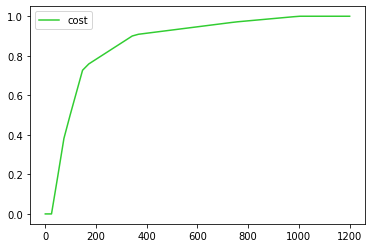

In [25]:
# 손실함수 그래프 시각화
def strictly_increasing(L):
    return all(x<y for x, y in zip(L, L[1:]))

def strictly_decreasing(L):
    return all(x>y for x, y in zip(L, L[1:]))

def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_increasing(L) or non_decreasing(L)

xnew = np.linspace(0, 1200, endpoint=True)

print('증가함수:', strictly_increasing(cost_function(xnew)))
print('단조증가함수:', non_decreasing(cost_function(xnew)))
print()

plt.plot(xnew, cost_function(xnew), color = 'limegreen')
plt.legend(['cost'])
plt.show()

# C행렬 생성

In [26]:
# [df_khd_50, df_khd_bins_added, df_others_50, df_others_bins_added] 4가지 경우에 대해서 각각 행렬 C 생성
df_list = [df_khd_50, df_khd_bins_added, df_others_50, df_others_bins_added]
C_name = ['C_khd_50', 'C_khd_bins_added', 'C_others_50', 'C_others_bins_added']
for idx, df_ in enumerate(df_list):
    df_target = df_    # 변환할 dataframe
    name = C_name[idx]        # C 행렬 이름
    
    length = df_target.shape[0]
    C = np.zeros(shape=(length, length))
    
    # i: node, j: facility
    for i in range(length):
        for j in range(length):
            C[i,j] = cal_obj(df_target.loc[i][2], df_target.loc[i][0], df_target.loc[i][1], df_target.loc[j][0], df_target.loc[j][1])
    
    pd.DataFrame(C).to_csv(f'{name}.csv', header=None, index=False)    

# CA알고리즘 함수 정의

In [27]:
import math
from collections import defaultdict

def CA(C, p, n):
    selected = [ChooseFirstNode(C)]

    for _ in range(1, p):
        P0 = selected + [GetNewNode(C, p, n, selected)]
        P1 = selected[:-1] + [P0[-1]] + [GetNewNode(C, p, n, selected[:-1] + [P0[-1]] )]
        P0Sum = GetFullCost(C, n, P0)
        P1Sum = GetFullCost(C, n, P1)
        selected = P0 if P0Sum < P1Sum else P1

    return selected

def GetNewNode(C, p, n, selected):
    closest = []
    for col in range(n):
        closest.append(min( C[selected][:, col] ))

    bestRow = 0
    bestScore = 0

    for row in range(n):
        if row in selected:
            continue
        score = 0
        for col in range(n):
            if C[row][col] < closest[col]:
                score += (closest[col] - C[row][col])
        
        if score > bestScore:
            bestRow = row
            bestScore = score

    return bestRow

def GetFullCost(C, n, selected):

    cost = 0
    matrix = C[selected]
    for col in range(n):
        cost += min(matrix[:, col])

    return cost
  
def ChooseFirstNode(C):
    minSum = float('inf')
    node = 0
    for idx, row in enumerate(C):
        tempSum = sum(row)
        if (tempSum < minSum):
            node = idx
            minSum = tempSum  
    return node



In [28]:
# C행렬, dataframe 불러오기
C_khd = pd.read_csv('C_khd_50.csv', encoding = 'utf8', header=None)
C_khd_bins_added = pd.read_csv('C_khd_bins_added.csv', encoding = 'utf8', header=None)
C_others = pd.read_csv('C_others_50.csv', encoding = 'utf8', header=None)
C_others_bins_added = pd.read_csv('C_others_bins_added.csv', encoding = 'utf8', header=None)

df_khd_bins_added = pd.read_csv('df_khd_bins_added.csv', encoding = 'utf8')
df_others_bins_added = pd.read_csv('df_others_bins_added.csv', encoding = 'utf8')
df_bin_khd = pd.read_csv('df_bin_khd.csv', encoding = 'utf8')
df_bin_others = pd.read_csv('df_bin_others.csv', encoding = 'utf8')

# 방법1을 이용할때의 비용과 최적해 계산

In [29]:
# C_khd_50 (금호동)
np_C_khd = np.array(C_khd)
np_C_khd = np_C_khd.T
res = CA(np_C_khd, 12, 13)
print('cost:\n', GetFullCost(np_C_khd, 13, res), '\n')
print('solution:\n', res)

cost:
 1.8494493460761672e-05 

solution:
 [3, 4, 0, 7, 1, 5, 11, 2, 9, 10, 12, 6]


In [30]:
# C_others_50 (그 외 지역)
# 여기서 GetFullCost함수를 통해 구한 비용은 기존분리수거장과 그 반경 50m이내에 존재하는 공동주택을 반영하지 못한 비용으로
# 기존부리수거장과 배제된 공동주택을 포함한 실제적인 비용을 구하기 위해서 아래에서 함수를 정의하여 계산한다.
np_C_others = np.array(C_others)
np_C_others = np_C_others.T
res = CA(np_C_others, 38, 136)
print('cost:\n', GetFullCost(np_C_others, 136, res), '\n')
print('solution:\n', res)

cost:
 0.10234335044319375 

solution:
 [19, 46, 94, 1, 97, 105, 21, 124, 69, 86, 44, 12, 54, 130, 133, 111, 67, 118, 128, 6, 135, 40, 81, 25, 52, 27, 101, 14, 119, 87, 117, 122, 39, 82, 72, 37, 49, 47]


# 방법2를 이용할때의 비용과 최적해 계산

In [31]:
# df_khd_bins_added에서 기존 분리수거함의 index 뽑아내기 (C_khd_bins_added 할 때 필요)
index_list = []
for row in df_khd_bins_added.to_numpy():
    in_both = 0
    for row2 in df_bin_khd.to_numpy():
        if row[1] == row2[1] and row[2] == row2[2]:
            in_both = 1

    if in_both == 1:
        index_list.append(int(row[0]))

print(len(index_list))        
print(index_list)
khd_bin_index = index_list

11
[1, 2, 3, 4, 6, 7, 12, 14, 15, 17, 21]


In [32]:
# df_others_bins_added에서 기존 분리수거함의 index 뽑아내기 (C_others_bins_added 할 때 필요)
index_list = []
for row in df_others_bins_added.to_numpy():
    in_both = 0
    for row2 in df_bin_others.to_numpy():
        if row[1] == row2[1] and row[2] == row2[2]:
            in_both = 1

    if in_both == 1:
        index_list.append(int(row[0]))

print(len(index_list))
print(index_list)
others_bin_index = index_list

81
[0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 16, 17, 20, 21, 24, 27, 29, 32, 33, 34, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 61, 67, 78, 82, 83, 88, 89, 91, 93, 96, 98, 99, 100, 101, 105, 107, 108, 112, 114, 125, 129, 131, 133, 141, 143, 144, 147, 149, 155, 157, 160, 165, 170, 177, 182, 183, 216, 217, 220, 222, 223]


In [33]:
# C_khd_bins_added 금호동 최적위치index와 비용 산출
def CA_bins_added(C, p, n):
    curr = p
    while True:
        res_plus = CA(C, curr, n)
        res = list(filter(lambda x: not alreadyExists_khd(x), res_plus))
        print(res)
        if (len(res) < p):
            curr += 1
        else:
            return res, res_plus

def alreadyExists_khd(idx):
    [lat, lon] = df_khd_bins_added.loc[idx, ['lat', 'lon']]
    for i in range(len(df_bin_khd)):
        d = df_bin_khd.loc[i]
        if lat == d['lat'] and lon == d['lon']:
            return True
    return False


np_C_khd_bins_added = np.array(C_khd_bins_added)
np_C_khd_bins_added = np_C_khd_bins_added.T

res, res_plus = CA_bins_added(np_C_khd_bins_added, 12, 25)
print('\ncost:\n', GetFullCost(np_C_khd_bins_added, 25, res+khd_bin_index), '\n')
print('solution:\n', res)

[16, 9, 10, 0]
[16, 9, 10, 0]
[16, 9, 10, 0, 18]
[16, 9, 10, 0, 18, 11]
[16, 9, 10, 0, 18, 11, 5]
[16, 9, 10, 0, 18, 11, 5, 23]
[16, 9, 10, 0, 18, 11, 5, 23, 8]
[16, 9, 10, 0, 18, 11, 5, 23, 8, 20]
[16, 9, 10, 0, 18, 11, 5, 23, 8, 20, 22]
[16, 9, 10, 0, 18, 11, 5, 23, 8, 20, 22, 24]

cost:
 1.8494493460761672e-05 

solution:
 [16, 9, 10, 0, 18, 11, 5, 23, 8, 20, 22, 24]


In [34]:
# C_others_bins_added 그 외 지역 최적위치index와 비용 산출
def CA_bins_added(C, p, n):
        curr = p
        while True:
            res_plus = CA(C, curr, n)
            res = list(filter(lambda x: not alreadyExists_others(x), res_plus))
            print(res)
            if (len(res) < p):
                curr += 1
            else:
                return res, res_plus

def alreadyExists_others(idx):
    [lat, lon] = df_others_bins_added.loc[idx, ['lat', 'lon']]
    for i in range(len(df_bin_others)):
        d = df_bin_others.loc[i]
        if lat == d['lat'] and lon == d['lon']:
            return True
    return False

np_C_others_bins_added = np.array(C_others_bins_added)
np_C_others_bins_added = np_C_others_bins_added.T

res, res_plus = CA_bins_added(np_C_others_bins_added, 38, 231)
print('\ncost:\n', GetFullCost(np_C_others_bins_added, 231, res+others_bin_index), '\n')
print('solution:\n', res)

[104, 60, 103, 181, 81, 28]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156]
[104, 60, 103, 181, 81, 28, 156, 179]
[104, 60, 103, 181, 81, 28, 156, 179]
[104, 60, 103, 181, 81, 28, 156, 179]
[104, 60, 103, 181, 81, 28, 156, 179]
[104, 60, 103, 181, 81, 28, 156, 179]
[104, 60, 103, 181, 81, 28, 156, 179, 4]
[104, 60, 103, 181, 81, 28, 156, 179, 4, 87]
[104, 60, 103, 181, 81, 28, 156, 179

# 최종 위치 도출

In [35]:
# 데이터 불러오기
data1 = pd.read_csv('1.광양시_공동주택_분리수거현황.csv')
data4 = pd.read_csv('4.광양시_건축물_표제부.csv')
data6 = gpd.read_file('6.광양시_법정경계(읍면동).geojson')
data7 = gpd.read_file('7.광양시_도로명주소(건물).geojson')
data8 = gpd.read_file('8.광양시_도로명주소(건물출입구).geojson')
data9 = gpd.read_file('9.광양시_지적도.geojson')
data10 = gpd.read_file('10.광양시_인구정보(총인구).geojson')

df = pd.read_csv('df.csv', index_col=0)
df_khd = pd.read_csv('df_khd.csv', index_col=0)
df_others = pd.read_csv('df_others.csv', index_col=0)

df_khd_50 = pd.read_csv('df_khd_50.csv', index_col=0)
df_others_50 = pd.read_csv('df_others_50.csv', index_col=0)

df_khd_bins_added = pd.read_csv('df_khd_bins_added.csv', index_col=0)
df_others_bins_added = pd.read_csv('df_others_bins_added.csv', index_col=0)

df_bin_khd = pd.read_csv('df_bin_khd.csv', index_col=0)
df_bin_others = pd.read_csv('df_bin_others.csv', index_col=0)

In [36]:
# 앞에서 구한 자동수거기 추가배치 최적위치 index

#방법1
sol_khd_50 = [3, 4, 0, 7, 1, 5, 11, 2, 9, 10, 12, 6]
sol_others_50 = [19, 46, 94, 1, 97, 105, 21, 124, 69, 86, 44, 12, 54, 130, 133, 111, 67, 118, 128, 6, 135, 40, 81, 25, 52, 27, 101, 14, 120, 87, 117, 122, 39, 82, 72, 37, 49, 47]
#방법2
sol_khd_bin = [16, 9, 10, 0, 18, 11, 5, 23, 8, 20, 22, 24]
sol_others_bin = [104, 60, 103, 181, 81, 28, 156, 179, 4, 87, 185, 110, 214, 63, 167, 193, 117, 225, 228, 97, 136, 199, 30, 134, 206, 230, 187, 211, 68, 158, 90, 221, 207, 205, 168, 35, 18, 109]


# 위에서 구한 비용이 맞는지 앞에서 구한 추가배치 최적위치 index를 이용한 cost 계산 함수를 만들어 검증

In [37]:
# 구한 해를 가지고 따로 cost 계산 (기존 분리수거장까지 고려)

# index랑 df로 구하는 함수
def cal_obj_for_sol(sol, df_cand, all, bin): 
    obj = 0

    new_bin = df_cand.iloc[sol]
    any_bin = pd.concat([new_bin, bin]).reset_index(drop=True) # 기존 분리수거함 or 새로 설치한 자동수거기가 있는 곳

    nodes = all.to_numpy()
    facility = any_bin[['lat', 'lon']].to_numpy()


    for node in nodes:
        dis = closest_bin(node[0], node[1], facility)
        obj += predict_recycle(node[2]) * cost_function(dis)

    return obj

# 좌표로 구하는 함수
def cal_obj_for_sol_2(new_bin, all, bin): 
    obj = 0

    any_bin = pd.concat([new_bin, bin]).reset_index(drop=True) # 기존 분리수거함 or 새로 설치한 자동수거기가 있는 곳

    nodes = all.to_numpy()
    facility = any_bin[['lat', 'lon']].to_numpy()

    for node in nodes:
        dis = closest_bin(node[0], node[1], facility)
        obj += predict_recycle(node[2]) * cost_function(dis)

    return obj

In [38]:
# 검증 계산

# 방법1
print('=============방법1 (금호동)=============')
sol1, df_cand1, all1, bin1 = sol_khd_50, df_khd_50, df_khd, df_bin_khd
print('비용 : ',cal_obj_for_sol(sol1, df_cand1, all1, bin1))
print('=============방법1 (그 외 지역)=============')
sol2, df_cand2, all2, bin2 = sol_others_50, df_others_50, df_others, df_bin_others
print('비용 : ',cal_obj_for_sol(sol2, df_cand2, all2, bin2))

# 방법2
print('=============방법2 (금호동)=============')
sol3, df_cand3, all3, bin3 = sol_khd_bin, df_khd_bins_added, df_khd, df_bin_khd
print('비용 : ',cal_obj_for_sol(sol3, df_cand3, all3, bin3))
print('=============방법2 (그 외 지역)=============')
sol4, df_cand4, all4, bin4 = sol_others_bin, df_others_bins_added, df_others, df_bin_others
print('비용 : ',cal_obj_for_sol(sol4, df_cand4, all4, bin4))

=============방법1 (금호동)=============
비용 :  1.8494493460761672e-05
=============방법1 (그 외 지역)=============
비용 :  0.12293752489032819
=============방법2 (금호동)=============
비용 :  1.8494493460761672e-05
=============방법2 (그 외 지역)=============
비용 :  0.11321403918453264


# 방법1, 방법2 비교

In [39]:
# 금호동

sol_50, df_cand_50 = sol_khd_50, df_khd_50
sol_bin, df_cand_bin = sol_khd_bin, df_khd_bins_added

sol_point_50 = df_cand_50.iloc[sol_50][['lat', 'lon']]
sol_point_50 = sol_point_50.sort_values(by=['lat', 'lon']).reset_index(drop=True)
sol_point_bin = df_cand_bin.iloc[sol_bin][['lat', 'lon']]
sol_point_bin = sol_point_bin.sort_values(by=['lat', 'lon']).reset_index(drop=True)

print('방법1 자동수거기 배치 위치 개수:', sol_point_50.shape[0])
rows_both = pd.merge(sol_point_50, sol_point_bin, on=['lat', 'lon'], how='inner').shape[0]
print('방법1, 방법2 자동수거기 배치 위치 겹치는 개수:', rows_both)
print('결과 일치 여부:', sol_point_50.equals(sol_point_bin))

# 결과
# 금호동은 방법1, 2 결과 같음 (12개 중 12개 일치)

방법1 자동수거기 배치 위치 개수: 12
방법1, 방법2 자동수거기 배치 위치 겹치는 개수: 12
결과 일치 여부: True


In [40]:
# 그 외 지역
sol_50, df_cand_50 = sol_others_50, df_others_50
sol_bin, df_cand_bin = sol_others_bin, df_others_bins_added

sol_point_50 = df_cand_50.iloc[sol_50][['lat', 'lon']]
sol_point_50 = sol_point_50.sort_values(by=['lat', 'lon']).reset_index(drop=True)
sol_point_bin = df_cand_bin.iloc[sol_bin][['lat', 'lon']]
sol_point_bin = sol_point_bin.sort_values(by=['lat', 'lon']).reset_index(drop=True)

print('방법1 자동수거기 배치 위치 개수:', sol_point_50.shape[0])
rows_both = pd.merge(sol_point_50, sol_point_bin, on=['lat', 'lon'], how='inner').shape[0]
print('방법1, 방법2 자동수거기 배치 위치 겹치는 개수:', rows_both)
print('결과 일치 여부:', sol_point_50.equals(sol_point_bin))

# 결과
# 그 외 지역은 방법1, 2 결과 다름 (38개 중 28개 일치)

방법1 자동수거기 배치 위치 개수: 38
방법1, 방법2 자동수거기 배치 위치 겹치는 개수: 28
결과 일치 여부: False


# 비교군 설치위치와 CA알고리즘으로 도출한 위치 비용 비교 

In [59]:
# 비교군이랑 비용 비교 
# 비교군 : 가장 세대 수가 많은 공동주택 상위 금호동 12곳, 그 외 지역 38곳으로 (이미 분리수거함 있는 곳만 제외하고) 선택하여 자동수거기 설치

df_bin = pd.read_csv('1.광양시_공동주택_분리수거현황.csv')
df_bin = df_bin[['lat', 'lon']].drop_duplicates()
np_bin = df_bin.to_numpy()

# 기존 분리수거함이랑 위치 같은 공동주택만 제외
df_khd['closest_bin'] = df_khd.apply(lambda x: closest_bin(x['lat'], x['lon'], np_bin), axis=1)
df_khd_0 = df_khd.drop(df_khd[df_khd.closest_bin <= 0.001].index)[['lat', 'lon', 'household_cnt']].reset_index(drop=True) 
df_khd = df_khd[['lat', 'lon', 'household_cnt']]

df_others['closest_bin'] = df_others.apply(lambda x: closest_bin(x['lat'], x['lon'], np_bin), axis=1)
df_others_0 = df_others.drop(df_others[df_others.closest_bin <= 0.001].index)[['lat', 'lon', 'household_cnt']].reset_index(drop=True) 
df_others = df_others[['lat', 'lon', 'household_cnt']]

# 세대수 가장 많은 많은 순서대로 선택
df_khd_comp = df_khd_0.sort_values(by=['household_cnt'], ascending=False)[0:12].reset_index(drop=True)
df_others_comp = df_others_0.sort_values(by=['household_cnt'], ascending=False)[0:38].reset_index(drop=True)

print(df_khd_0.shape[0])
print(df_others_0.shape[0])

14
150


In [56]:
# 금호동 cost 계산
new_bin, all, bin = df_khd_comp, df_khd, df_bin_khd
cal_obj_for_sol_2(new_bin, all, bin)

5.642608942157544e-05

In [57]:
# 그 외 지역 cost 계산
new_bin, all, bin = df_others_comp, df_others, df_bin_others
cal_obj_for_sol_2(new_bin, all, bin)

0.15737558857176615

# 방법2로 구한 방법이 가장 적은 비용
# 비교군과 비교했을 때, 방법2의 알고리즘이 매우 효율적인것 확인가능

# 최적결과(방법2 사용) 시각화

In [44]:
# 금호동 지도에 표시 전처리
sol_khd, df_cand_khd, all_khd, bins_khd = sol_khd_bin, df_khd_bins_added, df_khd, df_bin_khd


# 모든 sol: 기존 분리수거함이랑 겹치는 곳 없는 것 확인함

new_bin_khd = df_cand_khd.iloc[sol_khd][['lat', 'lon']] # 자동수거기를 설치할 공동주택의 좌표
no_bin_khd = pd.concat([all_khd[['lat', 'lon']], new_bin_khd, new_bin_khd]).drop_duplicates(keep=False) # 자동수거기를 설치하지 않을 공동주택의 좌표 (차집합 이용)
bin_khd = bins_khd[['lat', 'lon']] # 기존 분리수거함의 좌표
print("=================금호동=================")
print('전체 공동주택 후보 개수:', df_cand_khd.shape[0])
print('자동수거기 설치해야할 개수:', new_bin_khd.shape[0])
print('자동수거기를 설치하지 않을 공동주택 개수:', no_bin_khd.shape[0])
print('기존 분리수거장 개수:', bin_khd.shape[0])

# 그 외 지역 지도에 표시 전처리
sol_others, df_cand_others, all_others, bins_others = sol_others_bin, df_others_bins_added, df_others, df_bin_others

new_bin_others = df_cand_others.iloc[sol_others][['lat', 'lon']] # 자동수거기를 설치할 공동주택의 좌표
no_bin_others = pd.concat([all_others[['lat', 'lon']], new_bin_others, new_bin_others]).drop_duplicates(keep=False) # 자동수거기를 설치하지 않을 공동주택의 좌표 (차집합 이용)
bin_others = bins_others[['lat', 'lon']] # 기존 분리수거함의 좌표
print("================그 외 지역===============")
print('전체 공동주택 후보 개수:', df_cand_others.shape[0])
print('자동수거기 설치해야할 개수:', new_bin_others.shape[0])
print('자동수거기를 설치하지 않을 공동주택 개수:', no_bin_others.shape[0])
print('기존 분리수거장 개수:', bin_others.shape[0])

=================금호동=================
전체 공동주택 후보 개수: 25
자동수거기 설치해야할 개수: 12
자동수거기를 설치하지 않을 공동주택 개수: 10
기존 분리수거장 개수: 11
================그 외 지역===============
전체 공동주택 후보 개수: 231
자동수거기 설치해야할 개수: 38
자동수거기를 설치하지 않을 공동주택 개수: 183
기존 분리수거장 개수: 81


In [45]:
# Visualization

def getcolor(feature):
    if feature['properties']['emd_nm'] == '금호동':
        return 'red'
    else:
        return 'gray'

center = (34.9363848, 127.7310154) # 금호동 동백아파트
zoom = 11

m_khd = folium.Map(location = center, 
               zoom_start = zoom,
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/YOUR_API_KEY/Base/{z}/{y}/{x}.png',
               attr = '광양시'
              )
m_others = folium.Map(location = center, 
               zoom_start = zoom,
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/YOUR_API_KEY/Base/{z}/{y}/{x}.png',
               attr = '광양시'
              )

folium.GeoJson(data6, style_function = lambda feature: {'fillColor': getcolor(feature)}).add_to(m_khd)
folium.GeoJson(data6, style_function = lambda feature: {'fillColor': getcolor(feature)}).add_to(m_others)
folium.TileLayer(tiles = 'http://api.vworld.kr/req/wmts/1.0.0/YOUR_API_KEY/Hybrid/{z}/{y}/{x}.png', attr = '광양시', overlay = True).add_to(m_khd)
folium.TileLayer(tiles = 'http://api.vworld.kr/req/wmts/1.0.0/YOUR_API_KEY/Hybrid/{z}/{y}/{x}.png', attr = '광양시', overlay = True).add_to(m_others)

In [46]:
# 금호동 
# 자동수거기를 설치하지 않는 공동주택
for index, row in no_bin_khd.iterrows():
    folium.Marker([row['lat'], row['lon']]).add_to(m_khd)
# 자동수거기를 설치하는 공동주택
for index, row in new_bin_khd.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='red', icon='recycle', prefix='fa')).add_to(m_khd)
# 기존 분리수거함
for index, row in bin_khd.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='green', icon='recycle', prefix='fa')).add_to(m_khd)
m_khd

In [47]:
# 그 외 지역
for index, row in no_bin_others.iterrows():
    folium.Marker([row['lat'], row['lon']]).add_to(m_others)
# 자동수거기를 설치하는 공동주택
for index, row in new_bin_others.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='red', icon='recycle', prefix='fa')).add_to(m_others)
# 기존 분리수거함
for index, row in bin_others.iterrows():
    folium.Marker([row['lat'], row['lon']], icon=folium.Icon(color='green', icon='recycle', prefix='fa')).add_to(m_others)
m_others

In [48]:
# 금호동 결과 저장
name = 'sol_point_khd_bin'
sol, df_cand = sol_khd_bin, df_khd_bins_added

new_bin = df_cand.iloc[sol][['lat', 'lon']].reset_index(drop=True)
print('length:', new_bin.shape[0])

new_bin.to_csv(f'{name}.csv', index=False)


length: 12


In [49]:
# 그 외 지역 결과 저장
name = 'sol_point_others_bin'
sol, df_cand = sol_others_bin, df_others_bins_added

new_bin = df_cand.iloc[sol][['lat', 'lon']].reset_index(drop=True)
print('length:', new_bin.shape[0])

new_bin.to_csv(f'{name}.csv', index=False)

length: 38


In [50]:
# 금호동 공동주택 최적해 위치
sol_point_khd_bin = pd.read_csv('sol_point_khd_bin.csv')
sol_point_khd_bin

,lat,lon
0,34.941267,127.733266
1,34.938398,127.720248
2,34.938626,127.729541
3,34.932698,127.719063
4,34.942146,127.731413
5,34.938894,127.728303
6,34.937276,127.730673
7,34.943110,127.731169
8,34.937925,127.730299
9,34.942553,127.732189


In [51]:
# 그 외 지역 공동주택 최적해 위치
sol_point_others_bin = pd.read_csv('sol_point_others_bin.csv')
sol_point_others_bin

,lat,lon
0,34.967325,127.721025
1,34.960347,127.727554
2,34.967214,127.583680
3,34.978266,127.591784
4,34.964441,127.712450
5,34.943110,127.689732
6,34.974893,127.575439
7,34.978135,127.587524
8,34.934324,127.701653
9,34.964685,127.720586


# 도출된 최적 공동주택위치 정보를 가지고 최종 위치를 선정하는 방법은 코드 작성이 아닌 보고서의 방법에 따라 수기로 진행하였다.